<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 13
### Applied Machine Learning


__1. [20 pts] Pre-process a single file using 20 frequency bins (i.e. M), and 2000 sampling
frequency (controls the number of data points), such as,__

`x, fs = librosa.load(Path_dataset+'cat_1.wav', sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')`

C:\Users\bjwil\Anaconda3\envs\torch\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\bjwil\Anaconda3\envs\torch\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


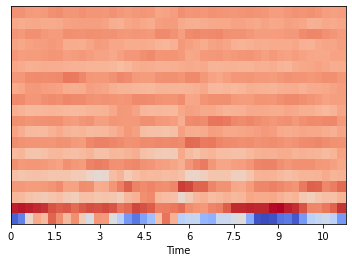

In [1]:
import librosa
import librosa.display
import glob
import numpy as np

Path_dataset = 'C:/Users/bjwil/JHU Classes/Machine Learning JHU/cats_dogs/'
SAMPLING_FRQ = 2000
BINS = 20

x, fs = librosa.load(Path_dataset+'cat_1.wav', sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

__2. [20 pts] For each wav file, you will have multiple data points, as generated by the `librosa.feature.mfcc`. Generate the X and y matrices for supervised learning. Apply your favorite classifier and comment about your results. (Hint: Expect 80-90% 10-fold CV accuracy, and `N, M = 7634, 20`)__

In [2]:
import re

files = [i for i in glob.glob(Path_dataset + '*.wav')]

r = re.compile('.*cats_dogs\\\\cat_*')
cat_files =  list(filter(r.match, files))

r = re.compile('.*cats_dogs\\\\dog_*')
dog_files =  list(filter(r.match, files))

print('# Cat files={}, # Dog files={}'.format(len(cat_files), len(dog_files)))

# Cat files=164, # Dog files=113


In [3]:
X = np.empty((0, 20))
y = np.empty((0,1))

## cat = 0 for target
for i in range(len(cat_files)):
    x, fs = librosa.load(cat_files[i], sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
    X = np.append(mfccs.T, X, axis=0)
    y = np.append(np.repeat(0, mfccs.T.shape[0]).reshape(-1,1), y, axis=0)

## dog = 1 for target   
for i in range(len(dog_files)):
    x, fs = librosa.load(dog_files[i], sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
    X = np.append(mfccs.T, X, axis=0)
    y = np.append(np.repeat(1, mfccs.T.shape[0]).reshape(-1,1), y, axis=0)

print(X.shape)
print(y.shape)

(7634, 20)
(7634, 1)


In [4]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

## first find best parameters
kfold = StratifiedKFold(n_splits=2, shuffle=True)

SVC_Pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
    ])

C = np.logspace(-4, 1, 6)
param_grid = dict(classifier__C=C,
                  classifier__kernel=['rbf', 'linear', 'poly'],
                  classifier__tol=np.logspace(-6,-2, 5))

grid_SVC = GridSearchCV(SVC_Pipeline, param_grid=param_grid,
                           cv=kfold, n_jobs=4, verbose=0,
                           scoring='accuracy')

grid_SVC.fit(X, y)
print('Best params:', grid_SVC.best_params_)
print('Best score:', grid_SVC.best_score_)

C:\Users\bjwil\Anaconda3\envs\torch\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'classifier__C': 10.0, 'classifier__kernel': 'rbf', 'classifier__tol': 1e-06}
Best score: 0.9510086455331412


In [5]:
## 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True)

SVC_Pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(C=10.0, kernel='rbf', tol=1e-06))
    ])

SVC_cross_validate = cross_validate(SVC_Pipeline, X, y.ravel(), cv=kfold, scoring='accuracy')

for k, v in SVC_cross_validate.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'SVC 10-fold cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')  

SVC 10-fold cross validation test_score is 0.968 ±0.0079


__3. [50 pts] Train a simple RNN, as given in the module Jupyter notebook, by shuffling the list
of the signals (the dataset has 277) and training the network sufficiently (suggested 50
times) and compare its performance to your previous evaluation in step (2.). A prediction
function is needed, such as,__
 
 `with torch.no_grad():
     hidden = rnn.init_hidden()
     sxx = torch.tensor(sxx, dtype=torch.float)
     for i in range(sxx.shape[0]):
     output, hidden = rnn.forward(sxx[i].reshape(1,rnn.n_features), hidden)
         y = 0 if ct=='cat' else 1
     y_pred = 0 if output[0][0]>output[0][1] else 1`

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, n_epochs, eta=0.0005):
        super(RNN, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        
        self.i2h = nn.Linear(n_features + n_hidden, n_hidden).float()
        self.i2o  = nn.Linear(n_features + n_hidden, n_output).float()
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.eta = eta
        self.criterion = nn.NLLLoss()
    
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros((1, self.n_hidden), dtype=torch.float)
       
    def train1(self, sxx, y):
        '''
        Trains 1 signal at a time
        '''
        self.zero_grad()
        hidden = self.init_hidden()
        N = sxx.shape[0]
                        
        for i in range(N):
            output, hidden = self.forward(sxx[i].reshape(1, self.n_features), hidden)
        
        loss = self.criterion(output, y)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-self.eta, p.grad.data)
        
        return output, loss.item()
    
    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            ## shuffle the indices
            indices = [i for i in range(len(X))]
            np.random.shuffle(indices)
                
            for i in indices:
                xi = torch.tensor(X[i], dtype=torch.float)
                yi = torch.tensor([y[i]], dtype=torch.long)
                output, loss = self.train1(xi, yi)
                ## for debugging
                top_n, top_i = output.topk(1)
                cat = top_i.item()
                #print("Train guessed: {}, actually was {}".format(cat, yi.numpy()[0]))
    
    def predict(self, X):
        predictions = []
        with torch.no_grad():
            for signal in X:
                hidden = self.init_hidden()
                xi = torch.tensor(signal, dtype=torch.float)
                ## this does same as loop in train
                for i in range(xi.shape[0]):
                    output, hidden = self.forward(xi[i].reshape(1, self.n_features), hidden)
                ## gets prediction by top probability
                ## see topk under https://pytorch.org/docs/stable/torch.html#comparison-ops
                top_n, top_i = output.topk(1)
                cat = top_i.item()
                predictions.append(cat)
        
        return predictions

In [7]:
## input lists for X and y
## We can use lists because we are just going to convert single signals and targets to tensors anyway

X_rnn = []
y_rnn = []

## cat = 0 for target
for i in range(len(cat_files)):
    x, fs = librosa.load(cat_files[i], sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
    X_rnn.append(mfccs.T)
    y_rnn.append(0)

## dog = 1 for target   
for i in range(len(dog_files)):  
    x, fs = librosa.load(dog_files[i], sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
    X_rnn.append(mfccs.T)
    y_rnn.append(1)
    
print(len(X_rnn))
print(len(y_rnn))

277
277


In [17]:
## train on 80% and test on 20%
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

X_train, X_test, y_train, y_test = train_test_split(X_rnn, y_rnn, train_size=.8)   

## create RNN instance
rnn = RNN(n_features=20, n_hidden=20, n_output=2, n_epochs=50, eta=.0005)  

## fit
rnn.fit(X_train, y_train)

## predict and get accuracy
y_pred = rnn.predict(X_test) 
print("Accuracy on 80/20 split =", accuracy_score(y_test, y_pred))  

Accuracy on 80/20 split = 0.7857142857142857


I was getting 85% accuracy.  Not sure why I am getting around 60-80% now.  I didn't change anything from running this Tuesday night.

__4. [10 pts] Compare and contrast the method applied in this assignment to the image classification.__

The RNN in this model is different to than the image classification is that at least for MNIST the images are all the same size.  For the tensorflow module in the text on page 443, however you can have different sized images.  In this model for the RNN the sizes of the audio file are different lengths are we reshaped so they would have at least the same amount of features.  You might be able to do this for different sized images but I don't think making them all have the same amount of features would work since then that would be the width for each image.  In the RNN we train 1 sample at a time at the end back propogate on all the time steps of that specific audio before upgrading the weights.  With the images classification in the MLP we train on batchs of samples, so not 1 at a time, and then back propogate the batch from all the outputs to the input of the batch and then update the weights with the learning rate and the delta weights calculated from the gradient.